# Lending Club Data Default Prediction

#### Antoni Szczepanik,  03.06.2018

Loan.csv is available at  https://www.kaggle.com/wendykan/lending-club-loan-data/data#loan.csv

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Machine learning
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initializing seed for reliability
np.random.seed(42)
# Setting display option to see all columns
pd.set_option('display.max_columns', None)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data preprocessing

### First look at the data

In [2]:
# Reading csv file into memory
df = pd.read_csv("data/data_raw.csv", low_memory=False)

# Sorting the columns alphabeticaly, for easier comparison with data dictionary excel file
df = df.reindex(sorted(df.columns), axis=1)
df.head()

,Unnamed: 0,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,929649,0.0,4.0,SD,29.0,65000.0,NaN,Individual,9733.0,57830.0,27.1,0.0,0.0000,0.0,N,NaN,NaN,1.0,0.0,NaN,Cash,16.06,NaN,Dec-1999,10+ years,Engineer,24700,24700.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,NaN,73.0,w,0.0,6.0,4.0,820.28,11.99,2015-12-01,Feb-2019,926.35,Jun-2016,24700,Fully Paid,6472.0,NaN,113.0,192.0,2.0,2.0,4.0,6.0,NaN,NaN,19.0,2.0,NaN,0.0,6.0,NaN,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,22.0,1.0,1.0,0.0,1.0,2.0,3.0,NaN,0.00,0.00,NaN,97.4,7.7,1,0.0,0.0,small_business,n,0.00,21470,NaN,19.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1,0.0,36 months,Business,0.0,204396.0,314017.0,38.0,39475.0,18005.0,79300.0,0.0,24667.0,25679.660000,25679.66,979.66,0.0,24700.00,111800.0,NaN,Not Verified,NaN,577xx
1,929650,0.0,0.0,AL,60.0,106000.0,NaN,Individual,37486.0,12875.0,67.2,0.0,863.6508,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,17.36,NaN,Apr-2002,7 years,Lieutenant,35000,35000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,NaN,43.0,w,0.0,0.0,0.0,794.21,12.88,2015-12-01,Feb-2019,794.21,Nov-2017,35000,Charged Off,9701.0,NaN,135.0,164.0,38.0,35.0,4.0,NaN,NaN,NaN,35.0,38.0,NaN,NaN,NaN,NaN,0.0,3.0,4.0,3.0,6.0,13.0,4.0,10.0,4.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,0.00,0.00,NaN,100.0,0.0,1,0.0,0.0,debt_consolidation,n,4798.06,39055,NaN,72.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C2,0.0,60 months,Debt consolidation,0.0,299890.0,366974.0,27.0,55067.0,16012.0,39200.0,4.0,36981.0,22208.070000,22208.07,7086.13,0.0,10323.88,54200.0,NaN,Source Verified,NaN,351xx
2,929651,0.0,3.0,MD,41.0,70000.0,NaN,Individual,1835.0,18527.0,44.0,0.0,1784.7000,0.0,Y,Nov-2017,NaN,0.0,0.0,NaN,Cash,

We have almost 900 000 rows of data, which is a lot. That will be useful later.
We also have 74 features. I suspect, that many of them will not be useful.
First I will check all the features descriptions, to eliminate those completely irrelevant.

The features that are completely irrelevant at the first sight are:
**'desc', 'emp_title', 'id', 'member_id', 'title'** and **'url'** 
We will not be using **'zip_code'** as well, as there is 'state' which contains the same information

In [3]:
df = df.drop(['desc', 'emp_title', 'id', 'member_id', 'title', 'url', 'zip_code'], axis=1)

## Data Cleaning

Now I will check how many features have missing values.
Then I will inspect if we can extract some information out of them

In [4]:
# Checking which colums still have missing values
missing_columns = df.columns[df.isnull().mean() != 0]
print('Number of columns with missing values:   ' + str(len(missing_columns)) + "\n")
df[missing_columns].isnull().mean()

Number of columns with missing values:   106



acc_now_delinq                         0.000033
acc_open_past_24mths                   0.056376
all_util                               0.975917
annual_inc                             0.000005
annual_inc_joint                       0.999424
avg_cur_bal                            0.079203
bc_open_to_buy                         0.065320
bc_util                                0.065903
chargeoff_within_12_mths               0.000163
collections_12_mths_ex_med             0.000163
debt_settlement_flag_date              0.979970
deferral_term                          0.996466
delinq_2yrs                            0.000033
delinq_amnt                            0.000033
dti                                    0.000002
dti_joint                              0.999426
earliest_cr_line                       0.000033
emp_length                             0.050522
hardship_amount                        0.996466
hardship_dpd                           0.996466
hardship_end_date                      0

I will delete all of features with more than 20% lacking values.
Imputing the lacking data would be risky, difficult and time consuming. 

In [5]:
# Dropping columns which have more than 20% missing values
df = df.drop(df.columns[df.isnull().mean() > 0.2], axis=1 )

df[df.columns[df.isnull().mean() != 0]].isnull().mean()

acc_now_delinq                0.000033
acc_open_past_24mths          0.056376
annual_inc                    0.000005
avg_cur_bal                   0.079203
bc_open_to_buy                0.065320
bc_util                       0.065903
chargeoff_within_12_mths      0.000163
collections_12_mths_ex_med    0.000163
delinq_2yrs                   0.000033
delinq_amnt                   0.000033
dti                           0.000002
earliest_cr_line              0.000033
emp_length                    0.050522
inq_last_6mths                0.000033
last_credit_pull_d            0.000053
last_pymnt_d                  0.000755
mo_sin_old_il_acct            0.107987
mo_sin_old_rev_tl_op          0.079191
mo_sin_rcnt_rev_tl_op         0.079191
mo_sin_rcnt_tl                0.079190
mort_acc                      0.056376
mths_since_recent_bc          0.064688
mths_since_recent_inq         0.154032
num_accts_ever_120_pd         0.079190
num_actv_bc_tl                0.079190
num_actv_rev_tl          

Some of the features lack very few values. I will remove the lacking records, as our dataset is big enough.
It will save me some problems with imputing missing data. 

In [6]:
# The columns are:
cols_to_drop = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'inq_last_6mths',
       'last_credit_pull_d', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies',
       'revol_util', 'tax_liens',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'debt_settlement_flag', 'disbursement_method', 'hardship_flag']

# Removing rows with missing values
df = df.drop(cols_to_drop, axis=1)

### Imputing missing data

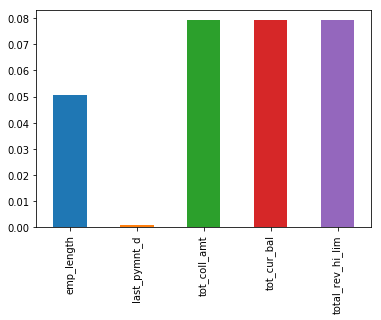

In [7]:
# Printing features that still lack values
df[df.columns[df.isnull().mean() != 0]].isnull().mean().plot(kind='bar')

We are left with 5 variables. I will impute missing data. 
First I will take a look at 'emp_length'. It takes values from 0 to 10

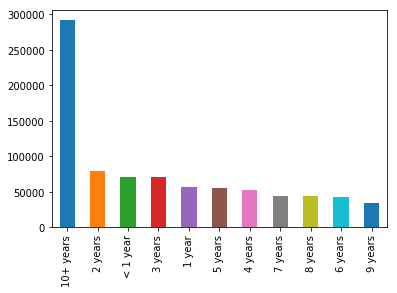

In [8]:
df['emp_length'].value_counts().plot(kind='bar')

First I will replace strings with integers. Then I will fill values that are not available with the most common occurence - 10+ years. 


In [9]:
# Replacing string with integers
condition = df['emp_length'] == '< 1 year'
df.loc[condition, 'emp_length'] = 0

condition = df['emp_length'] == '1 year'
df.loc[condition, 'emp_length'] = 1

condition = df['emp_length'] == '2 years'
df.loc[condition, 'emp_length'] = 2

condition = df['emp_length'] == '3 years'
df.loc[condition, 'emp_length'] = 3

condition = df['emp_length'] == '4 years'
df.loc[condition, 'emp_length'] = 4

condition = df['emp_length'] == '5 years'
df.loc[condition, 'emp_length'] = 5

condition = df['emp_length'] == '6 years'
df.loc[condition, 'emp_length'] = 6

condition = df['emp_length'] == '7 years'
df.loc[condition, 'emp_length'] = 7

condition = df['emp_length'] == '8 years'
df.loc[condition, 'emp_length'] = 8

condition = df['emp_length'] == '9 years'
df.loc[condition, 'emp_length'] = 9

condition = df['emp_length'] == '10+ years'
df.loc[condition, 'emp_length'] = 10

Now I will create sample, which I will pick from, and fill all missing values left with them.

In [10]:
# Filling missing values
df['emp_length'].fillna(10, inplace=True)
# Checking if fillna worked properly
df['emp_length'].isnull().sum()

0

We will do the same with 'last_pymnt_d'. 
But first I will convert the dates to numerical values. <br/> I decided to transform dates to time that passed since the last payment (in months).

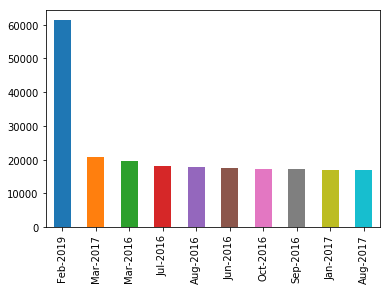

In [11]:
df['last_pymnt_d'].value_counts()[:10].plot(kind='bar')

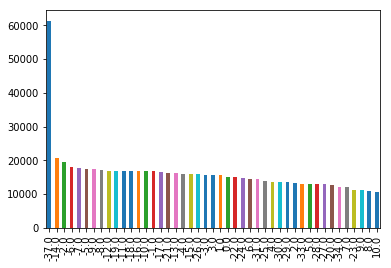

In [12]:
# Creating months dictionary
month_dict = {"Jan":1,"Feb":2,"Mar":3,"Apr":4, "May":5, "Jun":6, "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}

# Defining transformation function
def transform_date(series):
        string = str(series)
        if series == None or string == 'nan':
            return None
        year = int(string[-2:])
        month_name = string[0:3]
        month = month_dict[month_name]
        months_passed = None
        if month == 1 and year == 16:
            months_passed = 0
        else:
            months_passed = (12 * (15-year)) + (13 - month)
        return months_passed
   
        

# Applying transformation to new column
df['time_since_last_pymnt'] = df['last_pymnt_d'].apply(transform_date)

df['time_since_last_pymnt'].value_counts()[:10].plot(kind='bar')

Now I will again fill the missing with most common occurence - 0 months. 

In [13]:
# Filling missing values
df['time_since_last_pymnt'].fillna(0, inplace=True)
# Sanity check:
df['time_since_last_pymnt'].isnull().sum()

0

In [14]:
# Removing 'last_pymnt_d' column
df = df.drop(['last_pymnt_d'], axis=1)

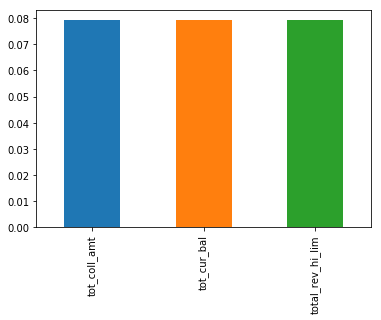

In [15]:
df[df.columns[df.isnull().mean() != 0]].isnull().mean().plot(kind='bar')

These features are continous. I decided to replace missing values with mean. Simple solutions often work best. 

In [16]:
# Calculating mean and filling missing values
mean_tot_coll = df['tot_coll_amt'].mean()
df['tot_coll_amt'].fillna(mean_tot_coll, inplace=True)

# Calculating mean and filling missing values
mean_tot_cur_bal = df['tot_cur_bal'].mean()
df['tot_cur_bal'].fillna(mean_tot_cur_bal, inplace=True)

# Calculating mean and filling missing values
mean_total_rev_hi_lim = df['total_rev_hi_lim'].mean()
df['total_rev_hi_lim'].fillna(mean_total_rev_hi_lim, inplace=True)

# Sanity check #2
df[['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']].isnull().mean()

tot_coll_amt        0.0
tot_cur_bal         0.0
total_rev_hi_lim    0.0
dtype: float64

### Our dataset is finally complete.

I removed all completely irrelevant features out of the dataset. All the missing values were handled as well. But's not all - let's move on to categorical features. 

# Dealing with categorical features

First I will check how many categorical features we have to deal with.

In [17]:
df.loc[:5, df.dtypes == object]

,addr_state,application_type,grade,home_ownership,initial_list_status,issue_d,loan_status,purpose,pymnt_plan,sub_grade,term,verification_status
0,SD,Individual,C,MORTGAGE,w,2015-12-01,Fully Paid,small_business,n,C1,36 months,Not Verified
1,AL,Individual,C,MORTGAGE,w,2015-12-01,Charged Off,debt_consolidation,n,C2,60 months,Source Verified
2,MD,Individual,C,OWN,w,2015-12-01,Charged Off,debt_consolidation,n,C4,60 months,Source Verified
3,RI,Individual,C,MORTGAGE,w,2015-12-01,Late (31-120 days),debt_consolidation,n,C2,36 months,Not Verified
4,WI,Individual,D,MORTGAGE,w,2015-12-01,Fully Paid,debt_consolidation,n,D5,60 months,Verified
5,CA,Individual,B,MORTGAGE,w,2015-12-01,Current,credit_card,n,B1,60 months,Source Verified


We are left with 16 categorical features. <br/>
I will convert them to integers or binary. <br/>
I will inspect each feature in detail, as it is crucial to represent the underlying data the best way possible.
 
As for addr_state I will perform onehot encoding. Probably most of them will be removed as insignificant later, but why not try?

In [18]:
# Performing OneHotEncoding 
df = df.join(pd.get_dummies(df['addr_state'], prefix='state'))
df.drop('addr_state', axis=1, inplace=True)
df.iloc[:5,45:]

,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Looks good. Now let's take a look at 'application_type'.

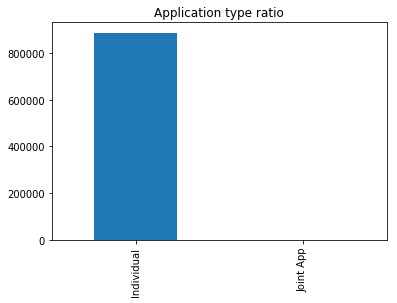

In [19]:
df['application_type'].value_counts().plot(kind='bar', title='Application type ratio')

The feature is very imbalanced, so I'll remove it.

In [20]:
df.drop('application_type',axis=1, inplace=True)

Let's take a look at potentially very important feature - grade. It also has a twin feature - sub_grade

In [21]:
print(df['grade'].value_counts())
df['sub_grade'].value_counts()[:7]

B    254553
C    245881
A    148207
D    139554
E     70707
F     23049
G      5489
Name: grade, dtype: int64


B3    56327
B4    55629
C1    53393
C2    52241
C3    50167
C4    48860
B5    48839
Name: sub_grade, dtype: int64

Interestingly, subgrade feature contains the same information. <br/>
That's why I will drop grade. <br/>
I decided to convert subgrades to integers in range <1,35> by the following rule: <br/>


A1 - 1<br/>
A2 - 2<br/>
...<br/>
B1 - 6<br/>
...<br/>
G5  - 35<br/>

In [22]:
# Dropping grade column
df.drop('grade', axis=1, inplace=True)

# Dictionary with alphabet - number transitions
alpha_dict = {'A': 0, 'B': 5, 'C': 10, 'D': 15, 'E': 20, 'F': 25, 'G': 30}

# Defining transformation function
def alpha_transform(series):
    
    string = str(series)
    number = alpha_dict[string[0]] + int(string[1])

    return number

# Applying transformation function
df['sub_grade'] = df['sub_grade'].apply(alpha_transform)
df['sub_grade'].value_counts()[:5]

8     56327
9     55629
11    53393
12    52241
13    50167
Name: sub_grade, dtype: int64

Now, let's take a look at 'home_ownership'

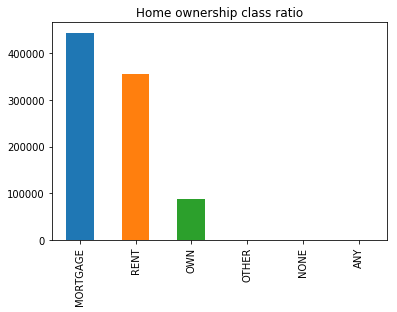

In [23]:
df['home_ownership'].value_counts().plot(kind='bar', title='Home ownership class ratio')

In this case I will perform one hot encoding again. I suspect that there may be important mappings hidden, even if the feature is strongly imbalance.

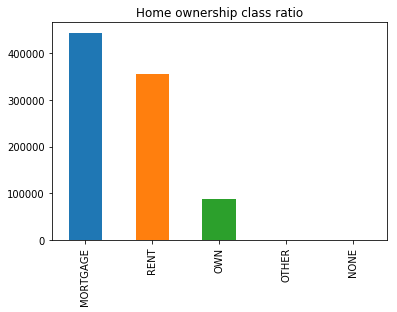

In [24]:
# I will convert all ANY values to OTHER first - they seem to represent the same:
def home_transform(series):
    string = str(series)
    if string == 'ANY':
        return 'OTHER'
    else: return series

# Apply transformation function
df['home_ownership'] = df['home_ownership'].apply(home_transform)
df['home_ownership'].value_counts().plot(kind='bar', title='Home ownership class ratio')

In [25]:
# Performing one hot encoding
df = df.join(pd.get_dummies(df['home_ownership'], prefix='home'))
df.drop('home_ownership', axis=1, inplace=True)
df.iloc[:5, -5:]

,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,1,0
3,1,0,0,0,0
4,1,0,0,0,0


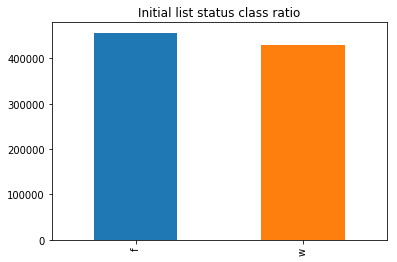

In [26]:
df['initial_list_status'].value_counts().plot(kind='bar', title='Initial list status class ratio')

In case of initial_list_status I will convert it to binary

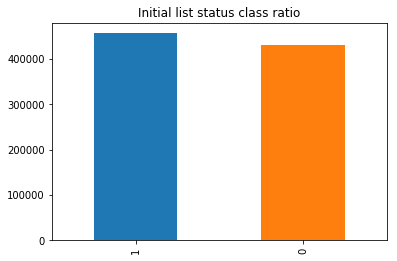

In [27]:
# Defining transformation function
def fw_transform(series):
    string = str(series)
    if string == 'f':
        return 1
    else:
        return 0

# Applying transformation function 
df['initial_list_status'] = df['initial_list_status'].apply(fw_transform)
df['initial_list_status'].value_counts().plot(kind='bar', title='Initial list status class ratio')   

In [28]:
df[['issue_d']].head()

,issue_d
0,2015-12-01
1,2015-12-01
2,2015-12-01
3,2015-12-01
4,2015-12-01


Now I will convert last_credit_pull_d and issue_d to months that have passed since. (as I already did before)

In [30]:
# Transformation dictionary
month_dict = {"Jan":1,"Feb":2,"Mar":3,"Apr":4, "May":5, "Jun":6, "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}

# Defining transformation function
def date_transform(series):
        
        series = str(series)
        year = int(series[-2:])
        month_name = series[0:3]
        try:
            month = month_dict[month_name]
        except:
            month = 0
            
        months_passed = None
        if month == 1 and year == 16:
            return 0
        else:
            return (12 * (15-year)) + (13 - month)

# Applying transformation function
df['issue_d'] = df['issue_d'].apply(date_transform)

df[ 'issue_d'].head()

0   -779
1   -779
2   -779
3   -779
4   -779
Name: issue_d, dtype: int64

Now let's convert crucial feature for us - our label 'loan_status'.

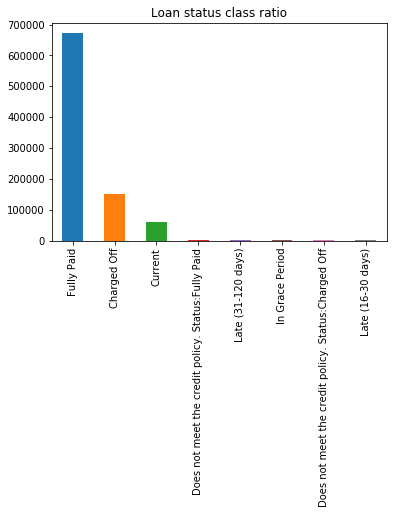

In [31]:
df['loan_status'].value_counts().plot(kind='bar', title='Loan status class ratio')

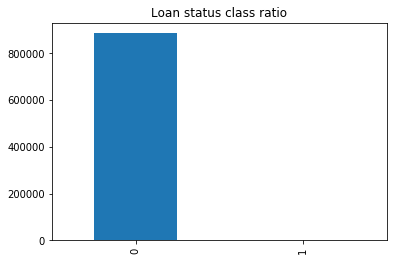

In [32]:
# Converting loan_status as stated in task description
loan_status_list = ['Charged off',
                    'Default',
                    'Does not meet the credit policy. Status: Charged Off',
                    'Late (31-120 days)']

def loan_status_transform(loan_status):
    loan_status = str(loan_status)
    if loan_status in loan_status_list:
        return 1
    else:
        return 0

# Applying transformation function
df['loan_status'] = df['loan_status'].apply(loan_status_transform)
df['loan_status'].value_counts().plot(kind='bar', title='Loan status class ratio')               

We already see that we have a serious imbalance in our data.
But for now let's focus on the last features which are not numeric.

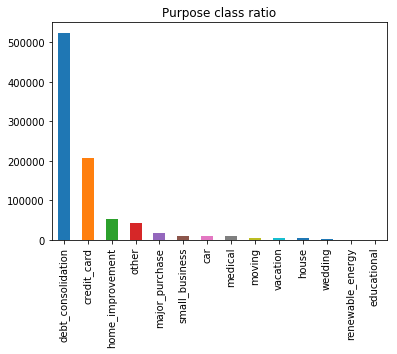

In [33]:
df['purpose'].value_counts().plot(kind='bar', title='Purpose class ratio')

In this case I will perform OneHotEncoding as well. 

In [34]:
# OneHotEncoding
df = df.join(pd.get_dummies(df['purpose'], prefix='purpose'))
df.drop('purpose', axis=1, inplace=True)
df.iloc[:5,-14:]

,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


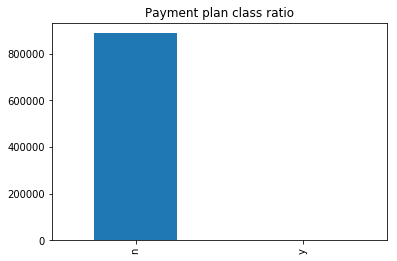

In [35]:
df['pymnt_plan'].value_counts().plot(kind='bar', title='Payment plan class ratio')

In case of payment plan only 10 values are of the opposite class. That is to little to keep this feature.

In [36]:
# Dropping pymnt_plan
df.drop("pymnt_plan", inplace=True, axis=1)

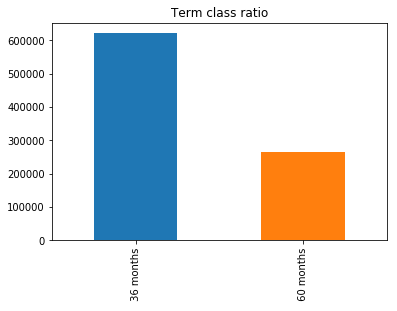

In [37]:
df['term'].value_counts().plot(kind='bar', title='Term class ratio')

Looking at term it is obvious to convert it to binary.

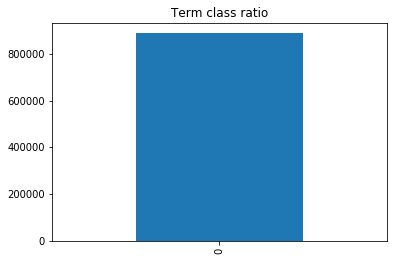

In [38]:
# Defining transformation function
def term_transform(term):

    term = str(term)
    if term == "60 months":
        return 1
    else:
        return 0
    
# Applying transformation function
df['term'] = df['term'].apply(term_transform)
df['term'].value_counts().plot(kind='bar', title='Term class ratio')

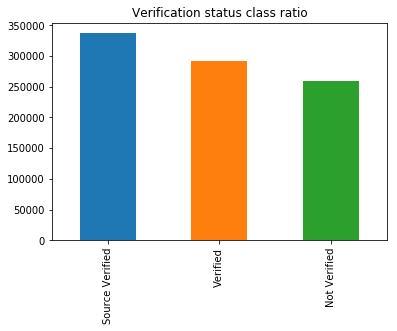

In [39]:
df['verification_status'].value_counts().plot(kind='bar', title='Verification status class ratio')

I will also convert Verified and Source Verified to one class - '1' in this case.
They seem to be very simmilar - in case of possibility to ask data provider this could be verified.

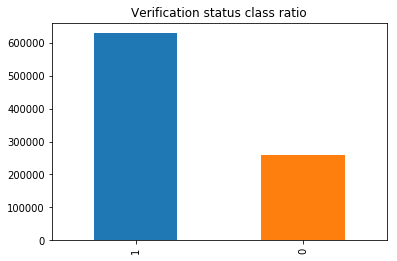

In [40]:
# Defining transformation function
def verification_transform(verif):

    verif = str(verif)
    if verif == "Not Verified":
        return 0
    else:
        return 1
    
# Applying transformation function
df['verification_status'] = df['verification_status'].apply(verification_transform)
df['verification_status'].value_counts().plot(kind='bar', title='Verification status class ratio')

In [41]:
df.info()
df.to_csv('df_cleaned.csv', sep=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887440 entries, 0 to 887439
Data columns (total 99 columns):
Unnamed: 0                    887440 non-null int64
collection_recovery_fee       887440 non-null float64
emp_length                    887440 non-null int64
funded_amnt                   887440 non-null int64
funded_amnt_inv               887440 non-null float64
initial_list_status           887440 non-null int64
installment                   887440 non-null float64
int_rate                      887440 non-null float64
issue_d                       887440 non-null int64
last_pymnt_amnt               887440 non-null float64
loan_amnt                     887440 non-null int64
loan_status                   887440 non-null int64
out_prncp                     887440 non-null float64
out_prncp_inv                 887440 non-null float64
policy_code                   887440 non-null int64
recoveries                    887440 non-null float64
revol_bal                     887440 non-

### And that's it. 
We are left only with numerical values and our dataset is complete. 

Before feeding it to any models I will test their importance - I didn't do in depth analysis of the particular features, but the chi2 test should do the job.